# Курсовая работа

Задание по итогам курса

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. 

На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет  https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.


In [1]:
!pip install facenet_pytorch

In [2]:
import numpy as np
import pandas as pd

import os
import cv2
import sys
import time
import random

import PIL
from PIL import Image

from IPython.core.debugger import set_trace

from facenet_pytorch import MTCNN

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Укажем некоторые параметры

In [4]:
train_path = "/content/drive/My Drive/Colab Notebooks/leapGestRecog/train"
test_path = "/content/drive/My Drive/Colab Notebooks/leapGestRecog/test"

In [5]:
CAT_JESTS = ["01_palm", '02_l','03_fist', '04_fist_moved', '05_thumb', 
              '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [6]:
num_classes = len(CAT_JESTS)
IMG_SIZE = 50
BATCH_SIZE = 8

In [7]:
class JestDataset(Dataset):
    
    def __init__(self, data_path, categories, img_size=50):
        self.path = data_path
        self.categories = categories
        self.img_size = img_size
        self.datalist = self.get_datalist(data_path, categories)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image_path, label = self.datalist[idx]
        img_arr = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(img_arr, (self.img_size, self.img_size))

        return (image, label)
                        
    def get_datalist(self, data_path, categories):
        datalist = []
        for dr in os.listdir(data_path):
            for category in categories:
                class_index = categories.index(category)
                path = os.path.join(data_path, dr, category)
                for img in os.listdir(path):
                    datalist.append([os.path.join(path, img), class_index])
        return datalist
    
    def __len__(self):
        return len(self.datalist)

In [8]:
train_dataset = JestDataset(train_path, CAT_JESTS)
test_dataset = JestDataset(test_path, CAT_JESTS)

Отобразим образцы фигур

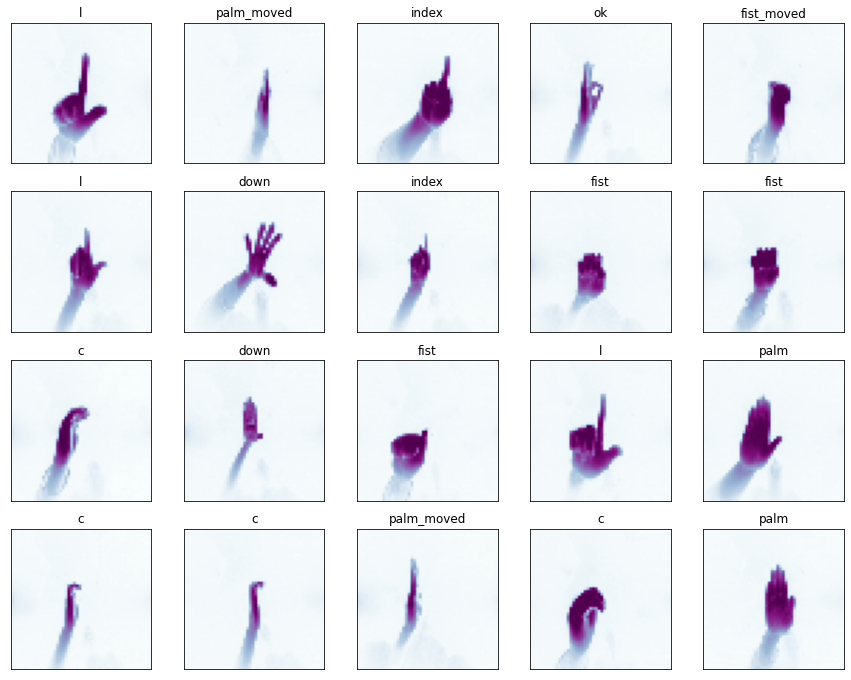

In [9]:
plt.figure(1, figsize=(15, 15))
for i in range(1, 20+1):
    idx = random.randint(0, train_dataset.__len__())
    img, label = train_dataset.__getitem__(idx)
    plt.subplot(5, 5, i)
    plt.imshow(img, cmap='BuPu')
    plt.xticks([])
    plt.yticks([])
    plt.title(CAT_JESTS[label][3:])
plt.show()

Расширим датасеты

In [10]:
train_trans = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                          # Настройки для расширения датасета
                          tt.RandomHorizontalFlip(),           # поворот на 90 градусов
                          tt.RandomRotation(45),               # поворот на 45 градусов
                          tt.ToTensor()])

test_trans = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [11]:
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, pin_memory=True)

In [12]:
train_dataloader.dataset.datalist.__getitem__(13000)

['/content/drive/My Drive/Colab Notebooks/leapGestRecog/train/06/06_index/frame_06_06_0026.png',
 5]

Создадим полезные функции

In [13]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [14]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

Создание модели

In [17]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = self.conv_block(in_channels, 128)
        self.conv2 = self.conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(self.conv_block(256, 256), self.conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = self.conv_block(256, 512)
        self.conv6 = self.conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
    
    @staticmethod
    def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ELU(inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [18]:
model = to_device(ResNet(1, num_classes), device)

In [19]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [20]:
if torch.cuda.is_available(): 
    torch.cuda.empty_cache()

epochs = 2
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [21]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

2 epochs, 2000 total_steps per epoch


Добавим learning_rate_sheduler:

In [22]:
print(torch.__version__)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dataloader))

1.7.0+cu101


In [ ]:
epoch_losses = []

for epoch in range(epochs):
    
    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data, labels = Variable(data), Variable(labels)
        # data = data.cuda()
        # labels = labels.cuda()
        # data.requires_grad = True
        
        data = data.to(device)
        labels = labels.to(device)
        
        
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(data)
            
            loss = loss_func(outputs, labels)
            loss.backward()

            face_optimizer.step()
            face_sheduler.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())

        """
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
        """
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Посмотрим на нашу ошибку в процессе обучения:

In [ ]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

Сохраним нашу модель:

In [ ]:
model_name = './models/jest_detection_model_state_2_epoch.pth'
torch.save(model.state_dict(), model_fp)

Теперь давайте загрузим ее и будем использовать:

In [ ]:
net=ResNet(1, len(classes_train)).to(device)
net.load_state_dict(torch.load(model_name))
net.eval()

Прогоним нашу нейронную сеть через тестовый датасет:

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_dl):
        images, labels = data
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = net(images)
        plt.title(f'gaused - {digit_to_classname(outputs[0].argmax())}, groud truth - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

Создадим объект, чтобы считать поток с веб-камеры

In [ ]:
cap = cv2.VideoCapture(0)

In [ ]:
# Класс детектирования и обработки жестов с веб-камеры 
class JestDetector(object):

    def __init__(self, mtcnn, resnet):
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = resnet

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks, emotion):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Something wrong im draw function!')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'sad'
        elif digit == 1:
            return 'disgust'
        elif digit == 2:
            return 'happy'
        elif digit == 3:
            return 'surprise'
        elif digit == 4:
            return 'neutral'
        elif digit == 5:
            return 'fear'
        elif digit == 6:
            return 'angry'
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                
                # Вырезаем лицо из кадра
                face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
                face = cv2.resize(face,(48,48))
                # Превращаем в 1-канальное серое изображение
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                emotion = self.emodel(torch_face[None, ...])
                # Интерпретируем предсказание как строку нашей эмоции
                emotion = self.digit_to_classname(emotion.argmax())

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks, emotion)

            except:
                print('Something wrong im main cycle!')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()

In [ ]:
# Загружаем мтцнн
mtcnn = MTCNN()

ourResNet = ResNet(1, num_classes).to(device)
ourResNet.load_state_dict(torch.load('./models/jest_detection_model_state_200_batch.pth'))
ourResNet.eval()
# Создаем объект нашего класса приложения
fcd = JestDetector(mtcnn, ourResNet)
# Запускаем
fcd.run()